In [1]:
%matplotlib inline

# TAREA 2

**Adapted from:** [Nathan Inkawhich](https://github.com/inkawhich)

In this task, we will look at how to create a model for image classification, the impact of transfer learning using models pretrained on the 1000-class Imagenet dataset. The most efficient parameters for each architectures are likely to change, so you must look at the existing architecture and make custom adjustments for each model.

We will try to learn using a model **trained from scratch**, to do **feature extraction** by using only the last layer of a pre-trained network and only update the final layer weights using our data and label (i.e., using the CNN as a fixed feature extractor), and to **fine-tune** a pretrained model and update *all* of the model’s parameters for our task.

More information about transfer learning [in the CS231n class of Standford](https://cs231n.github.io/transfer-learning/) and in [Sebastian Ruder's blog post](https://ruder.io/transfer-learning/).

### Goal

The goals for you are to
* Fill up the code at different points where you have `# TODO`,
* Try different hyper-parameters of the models, different training and evaluation settings in order to answer the questions
* In the end you will have to upload an image of yours to test your model on it!    

### Data

We will use an Emotion Recognition dataset derived from FlickR30k. It is available at [this link](https://www.dcc.uchile.cl/~vbarrier/Flicker_data). It is composed of images that have been automatically tagged with several different emotions: `amusement, anger, awe, contentment, disgust, excitement, fear, sadness`.

Download the data and set them in your google drive. The ``model_name`` input is the name of the model you wish to use and must
be selected from this list:
```python
['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet']
```

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
import shutil
from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score
import pandas as pd
import seaborn as sn
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  2.4.1+cu124
Torchvision Version:  0.19.1+cpu


### Inputs
   
The other inputs are as follows:
* ``num_classes`` is the number of classes in the dataset, which is 8 in our case
* ``batch_size`` is the batch size used for training and may be adjusted according to the capability of your machine, ``num_epochs`` is the number of training epochs we want to run,
* ``feature_extract`` is a boolean that defines if we are finetuning or feature extracting. If ``feature_extract = False``, the model is finetuned and all model parameters are updated. If ``feature_extract = True``, only the last layer parameters are updated, the others remain fixed
* `lr` which is the learning rate of the optimizer

In [3]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "../Flicker_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
model_name = "efficientnet_b2"

# Number of classes in the dataset
num_classes = 8

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 12

# learning rate of the optimizer
lr=0.001

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Flag for data augmentation. When True apply a random cropped, a random
#   flip on the training images, and a rotation.
data_augmentation = True

# if we want to top-N results;
#   set an integer if want the top-3 results for example, set None if not wanted
topNresults = 3

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Load Data
---------

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
[here](https://pytorch.org/docs/master/torchvision/models.html).


Two options to load the data:
* Option 1: Download the dataset, and put it directly in your Google Drive that you can access through colab. **This is better as you do not need to download the data everytime you are intiating a new colab instance. You will also be able to save your best model!**
* Option 2: Download the dataset directly on the colab instance

#### Option 1: Use the dataset already in my Google Drive

Here I am using as path of the project `'/content/drive/My Drive/DATASETS/deepemotion/'` where I should put the [dataset](https://users.dcc.uchile.cl/~vbarrier/Flicker_data/) `Flicker_data`. It means that I have it in my google drive under the path `'DATASETS/deepemotion/'`

#### Option 2: Download the data directly here

Helper Functions
----------------

Before we write the code for adjusting the models, lets define a few
helper functions.

**Model Training and Validation Code**

The ``train_model`` function handles the training and validation of a
given model. As input, it takes a PyTorch model, a dictionary of
dataloaders, a loss function, an optimizer, a specified number of epochs
to train and validate for, and a boolean flag for when the model is an
Inception model.
The function trains for the specified number of epochs and after each
epoch runs a full validation step. It also keeps track of the best
performing model (in terms of validation accuracy), and at the end of
training returns the best performing model. After each epoch, the
training and validation accuracies are printed.


In [4]:
def update_lists_for_f1_score(preds, labels, target_true, predicted_true, correct_true, all_labels):
  """
  Need to be executed at every batch in order to update the lists target_true, predicted_true and correct_true.
  target = TP + FN
  predicted_true = TP + FP
  correct_true = TP
  """
  # iterating over all the classes
  for class_k in all_labels:
    predicted_classes = preds == class_k
    target_classes = labels == class_k
    target_true[class_k] += torch.sum(target_classes).float()
    predicted_true[class_k] += torch.sum(predicted_classes).float()
    correct_true[class_k] += torch.sum(
        (predicted_classes) * (target_classes)).float()
  return target_true, predicted_true, correct_true

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10,
                   use_tqdm=False, name_model = 'best_model_no_feature_extraction.pt'):
    since = time.time()
    t0 = since

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to initialize the counters of the true
    dico_labels = image_datasets['val'].class_to_idx
    dico_labels_inverse = {v:k for k, v in dico_labels.items()}
    all_labels = dico_labels.values()
    dict_true_init = {idx_lab : 0 for idx_lab in all_labels}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            # Set model to training/evaluate mode
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            target_true = dict_true_init.copy()
            predicted_true = dict_true_init.copy()
            correct_true = dict_true_init.copy()

            # Iterate over data.
            array_for_loop = dataloaders[phase]
            if use_tqdm or (epoch == 0): # training is slow at 1st epoch
              array_for_loop = tqdm(array_for_loop)
            for inputs, labels in array_for_loop:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                # TODO
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # TODO
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # create predictions
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    # TODO
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                target_true, predicted_true, correct_true = update_lists_for_f1_score(preds, labels.data,
                                                    target_true, predicted_true, correct_true, all_labels)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # calculating F1
            recall = []
            precision = []
            f1_score = []
            # At the end of the epoch
            for k_class in range(len(set(all_labels))):
                recall.append(correct_true[k_class] / target_true[k_class])
                precision.append(correct_true[k_class] / predicted_true[k_class])
                f1_score.append(2 * precision[k_class] * recall[k_class] / (precision[k_class] + recall[k_class]))

            epoch_f1 = np.mean([k.cpu().numpy() for k in f1_score])

            time_epoch = time.time()-t0
            print('{} Loss: {:.4f} Acc: {:.4f}  F1: {:.4f} in {:.0f}m {:.0f}s'.format(phase, epoch_loss, epoch_acc,
                                                                          epoch_f1, time_epoch // 60, time_epoch % 60))


            # deep copy the model if best accuracy in this epoch
            if phase == 'val':
                str_to_write = 'F1 : '
                for k, v in dico_labels.items():
                    str_to_write += "'{}' : {:.4f}, ".format(k, f1_score[v])
                print(str_to_write)
                val_acc_history.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    print('Best model saved')
                    torch.save(model, 'temp_' + name_model)
                    best_model_wts = copy.deepcopy(model.state_dict())
            
            t0 = time.time()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

#### Set Model Parameters’ .requires_grad attribute

This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.




In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [6]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "efficientnet_b2":
        """ Efficientnet
        """
        model_ft = models.efficientnet_b2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

c:\Users\Daniel\Documents\GitHub\Deep-Learning\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Daniel\Documents\GitHub\Deep-Learning\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Creation Datasets and Dataloaders

Regarding Data Augmentation, use `transforms.RandomResizedCrop` and `transforms.RandomHorizontalFlip`, and also `transforms.RandomRotation` to see which one works best

In [7]:
def return_datasets_dataloaders(data_dir, input_size=224, angle_rotation=5, data_augmentation = True):
    """
    Create the datasets and dataloaders needed for the training
    """

    # apply data augmentation
    list_data_transform_data_aug = [
            # TODO
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(angle_rotation),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    # test without data_augmentation
    list_data_transform = [
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]

    # Data augmentation and normalization for training
    # Just normalization for validation
    if data_augmentation:
        data_transforms = {
            'train': transforms.Compose(list_data_transform_data_aug),
            'val': transforms.Compose(list_data_transform),
        }
    else: # no data augmentation in this case
        data_transforms = {
            'train': transforms.Compose(list_data_transform),
            'val': transforms.Compose(list_data_transform),
        }


    print("Initializing Datasets and Dataloaders"+data_augmentation*" with data augmentation"+"...")

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

    return image_datasets, dataloaders_dict

image_datasets, dataloaders_dict = return_datasets_dataloaders(data_dir, data_augmentation = data_augmentation)

# Detect if we have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders with data augmentation...


Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [8]:
# Send the model to GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=0.9)

Params to learn:
	 features.0.0.weight
	 features.0.1.weight
	 features.0.1.bias
	 features.1.0.block.0.0.weight
	 features.1.0.block.0.1.weight
	 features.1.0.block.0.1.bias
	 features.1.0.block.1.fc1.weight
	 features.1.0.block.1.fc1.bias
	 features.1.0.block.1.fc2.weight
	 features.1.0.block.1.fc2.bias
	 features.1.0.block.2.0.weight
	 features.1.0.block.2.1.weight
	 features.1.0.block.2.1.bias
	 features.1.1.block.0.0.weight
	 features.1.1.block.0.1.weight
	 features.1.1.block.0.1.bias
	 features.1.1.block.1.fc1.weight
	 features.1.1.block.1.fc1.bias
	 features.1.1.block.1.fc2.weight
	 features.1.1.block.1.fc2.bias
	 features.1.1.block.2.0.weight
	 features.1.1.block.2.1.weight
	 features.1.1.block.2.1.bias
	 features.2.0.block.0.0.weight
	 features.2.0.block.0.1.weight
	 features.2.0.block.0.1.bias
	 features.2.0.block.1.0.weight
	 features.2.0.block.1.1.weight
	 features.2.0.block.1.1.bias
	 features.2.0.block.2.fc1.weight
	 features.2.0.block.2.fc1.bias
	 features.2.0.block.2.fc

Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [ ]:
name_model = 'finetuned-efficientnet'+'.pt'

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs,
                             use_tqdm=False, name_model = name_model)

torch.save(model_ft, '{}/{}'.format(data_dir, name_model))

Epoch 0/11
----------


100%|██████████| 335/335 [09:48<00:00,  1.76s/it]


train Loss: 1.5784 Acc: 0.4580  F1: 0.3144 in 9m 49s


100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


val Loss: 1.5665 Acc: 0.4501  F1: 0.4036 in 0m 6s
F1 : 'amusement' : 0.6618, 'anger' : 0.0755, 'awe' : 0.7234, 'contentment' : 0.3503, 'disgust' : 0.4444, 'excitement' : 0.5000, 'fear' : 0.0417, 'sadness' : 0.4314, 
Best model saved

Epoch 1/11
----------
train Loss: 1.2508 Acc: 0.5692  F1: 0.4427 in 10m 1s
val Loss: 1.3744 Acc: 0.5243  F1: 0.4873 in 0m 5s
F1 : 'amusement' : 0.6724, 'anger' : 0.2373, 'awe' : 0.7600, 'contentment' : 0.4567, 'disgust' : 0.5979, 'excitement' : 0.5345, 'fear' : 0.1569, 'sadness' : 0.4828, 
Best model saved

Epoch 2/11
----------
train Loss: 1.1588 Acc: 0.5952  F1: 0.4876 in 9m 45s
val Loss: 1.2815 Acc: 0.5422  F1: 0.5135 in 0m 5s
F1 : 'amusement' : 0.6891, 'anger' : 0.2647, 'awe' : 0.7551, 'contentment' : 0.5156, 'disgust' : 0.5773, 'excitement' : 0.5607, 'fear' : 0.2456, 'sadness' : 0.5000, 
Best model saved

Epoch 3/11
----------
train Loss: 1.1044 Acc: 0.6106  F1: 0.5237 in 10m 6s
val Loss: 1.2361 Acc: 0.5754  F1: 0.5552 in 0m 5s
F1 : 'amusement' : 0.69

#### Plot hist

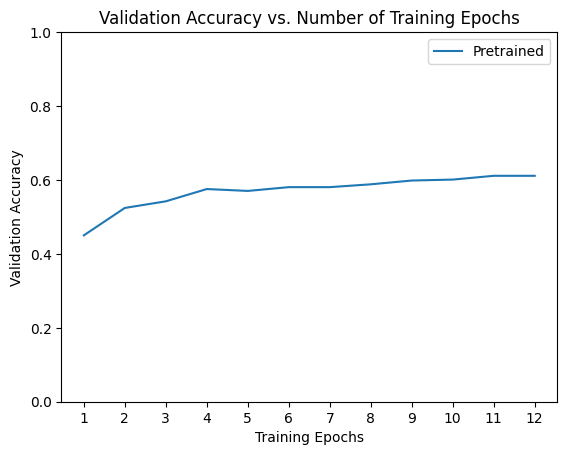

In [10]:
def plot_hist(hist):
  """
  Plot the training curves of validation accuracy vs. number of training epochs
  """
  ohist = []

  ohist = [h.cpu().numpy() for h in hist]

  plt.title("Validation Accuracy vs. Number of Training Epochs")
  plt.xlabel("Training Epochs")
  plt.ylabel("Validation Accuracy")
  plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
  # plt.plot(range(1,num_epochs+1),shist,label="Scratch")
  plt.ylim((0,1.))
  plt.xticks(np.arange(1, num_epochs+1, 1.0))
  plt.legend()
  plt.show()

plot_hist(hist)

### Some visualizations

We keep one model under the name `'fine_tune_total_best_accuracy.pt'` that obtained the scores below so that we can check it's F1 score.

Let's have a look at the model's predictions with
* the confusion matrix to see between which class is the confusion
* the top-N predictions to see if the model predict in which position it predicts the right class. It is important as emotion can be multi-class and are subjectives
* A aggregation of the emotions regarding their valence (positiveness)

## Preguntas

* Que pienses de la matriz de confusion?
* Porque hace sentido de mirar la accuracy topN?

## Respuestas

**Ponga tues respuestas aca**

### Test on our own images !

Funny test

## Preguntas

* Qué es un modelo pre-entrenado? Qué significa fine-tunear un modelo?
* Cuáles son las diferencias principales entre entrenar un modelo desde cero y usar Transfer Learning?
* Que pasa con las curvas de aprentizaje cuando utilizamos representaciones viniendo de un modelo ya pre-entrenado?
* A qué hace referencia Layer Freezing? ¿Cuáles podrían ser las ventajas de hacer esto?
* Cuales son las differencias entre extractar los atributos y fine-tunear la ultima capa o fine-tunear todos los parametros del red? Que pasa con las curvas de apprentizaje?
* Cual es el efecto de la aumentacion de datos? Como se puede ver? Que pasa con las curvas de aprentizaje?

## Respuestas

**Ponga tues respuestas aca**